In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/fashion-mnist_train.csv')
test_data = pd.read_csv('/content/drive/My Drive/fashion-mnist_test.csv')

In [ ]:
train_X = np.array(train_data.iloc[:,1:])
test_X = np.array(test_data.iloc[:,1:])
train_Y = np.array (train_data.iloc[:,0])
test_Y = np.array(test_data.iloc[:,0])

In [ ]:
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X] * 3)
train_X.shape, test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [ ]:
train_X = train_X.reshape(-1, 28, 28, 3)
test_X= test_X.reshape(-1, 28, 28, 3)
train_X.shape, test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [ ]:
train_X = train_X.astype('float32') / 255.
test_X = test_X.astype('float32') / 255.
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [ ]:
train_X, valid_X, train_label, valid_label = train_test_split(
    train_X,
    train_Y_one_hot,
    test_size=0.2,
    random_state=13
)

In [ ]:
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-u2tp5jlx
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-u2tp5jlx
  Running command git submodule update --init --recursive -q


In [ ]:
# for keras
from classification_models.keras import Classifiers

# for tensorflow keras
from classification_models.tfkeras import Classifiers

Classifiers.models_names()

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'seresnet18',
 'seresnet34',
 'seresnet50',
 'seresnet101',
 'seresnet152',
 'seresnext50',
 'seresnext101',
 'senet154',
 'resnet50v2',
 'resnet101v2',
 'resnet152v2',
 'resnext50',
 'resnext101',
 'vgg16',
 'vgg19',
 'densenet121',
 'densenet169',
 'densenet201',
 'inceptionresnetv2',
 'inceptionv3',
 'xception',
 'nasnetlarge',
 'nasnetmobile',
 'mobilenet',
 'mobilenetv2']

In [ ]:
SeResNeXT, preprocess_input = Classifiers.get('seresnext50')
model = SeResNeXT(include_top = False, input_shape=(48, 48, 3), weights='imagenet')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)   0           ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 24, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [ ]:
train_features = model.predict(np.array(train_X), batch_size=64, verbose=1)
test_features = model.predict(np.array(test_X), batch_size=64, verbose=1)
val_features = model.predict(np.array(valid_X), batch_size=64, verbose=1)

188/188 [==============================] - 21s 111ms/step


In [ ]:
train_features.shape, test_features.shape, val_features.shape

((48000, 2, 2, 2048), (10000, 2, 2, 2048), (12000, 2, 2, 2048))

In [ ]:
train_features_flat = np.reshape(train_features, (48000, -1))
test_features_flat = np.reshape(test_features, (10000, -1))
val_features_flat = np.reshape(val_features, (12000, -1))

In [ ]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers
from keras import callbacks
from keras.regularizers import l2

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
reduce_lr = callbacks.ReduceLROnPlateau(
    factor=0.2,
    patience=2,
    verbose=1,
    cooldown=2
)

In [ ]:
history = model.fit(
    train_features_flat,
    train_label,
    epochs=10,
    steps_per_epoch=500,
    validation_data=(val_features_flat, valid_label),
    callbacks=[reduce_lr]
)

Epoch 1/10
500/500 [==============================] - 10s 17ms/step - loss: 2.7445 - accuracy: 0.8084 - val_loss: 1.0516 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 8s 15ms/step - loss: 0.9005 - accuracy: 0.8299 - val_loss: 0.9457 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 8s 16ms/step - loss: 0.8722 - accuracy: 0.8305 - val_loss: 0.9035 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 9s 18ms/step - loss: 0.8247 - accuracy: 0.8360 - val_loss: 0.8318 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 8s 16ms/step - loss: 0.8007 - accuracy: 0.8406 - val_loss: 0.8597 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 8s 16ms/step - loss: 0.7527 - accuracy: 0.8470 - val_loss: 0.8005 - val_accuracy: 0.8255 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 9s 18ms/s

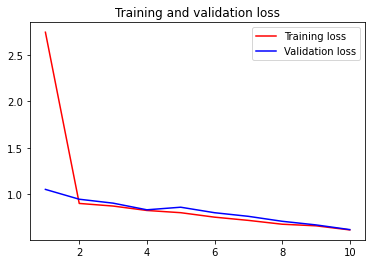

In [ ]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)



plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()